Mounted at /content/drive/


  0%|          | 0/51 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 100:  98%|█████████▊| 50/51 [05:00<00:02,  2.28s/batch, loss=0.00199, psnr=15]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Test: 100%|██████████| 7/7 [00:11<00:00,  1.66s/batch, loss=0.0022]


--------------------------------------------------


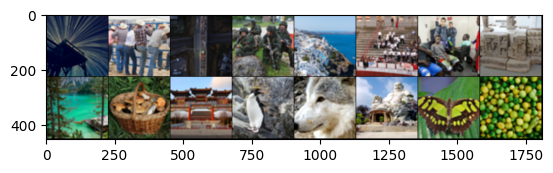

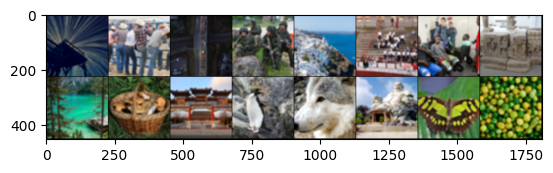

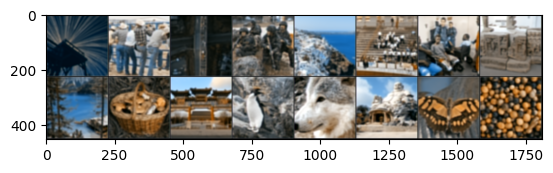

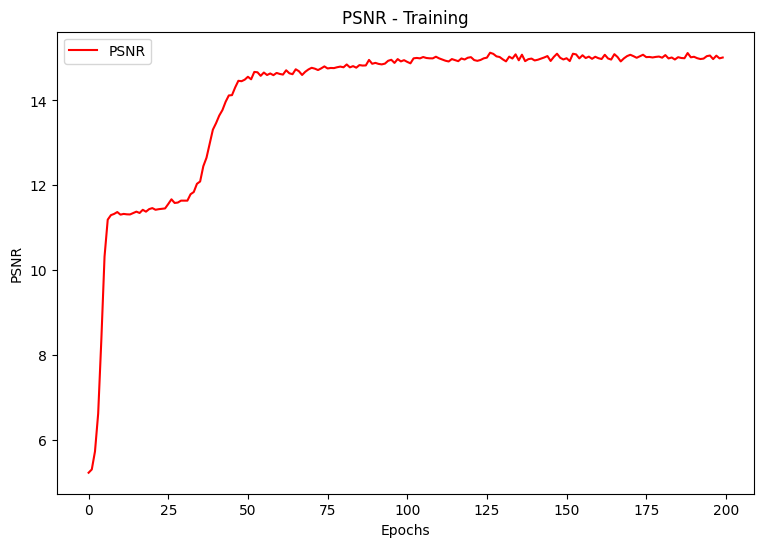

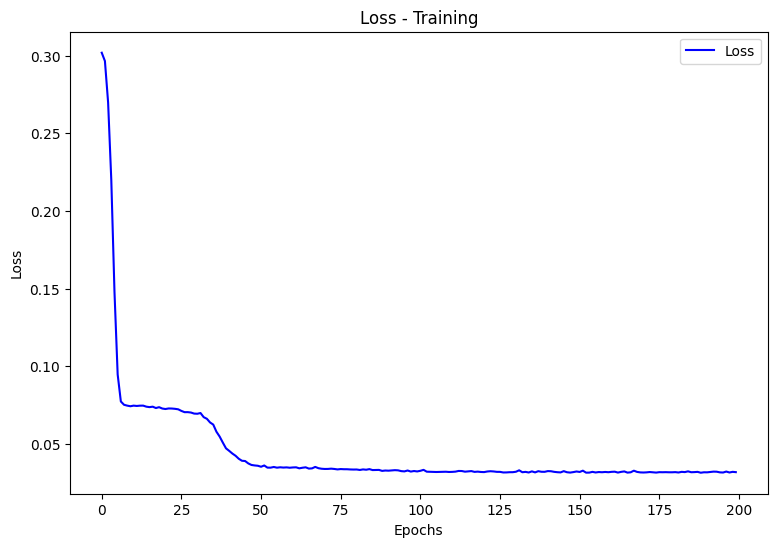

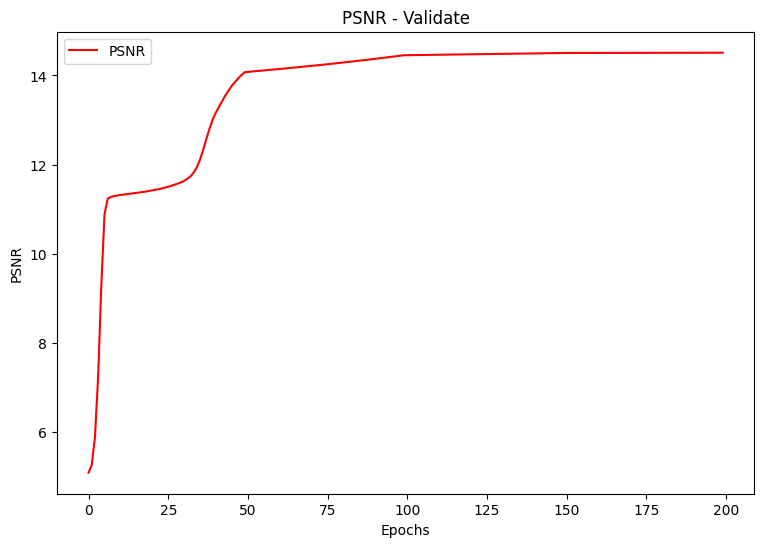

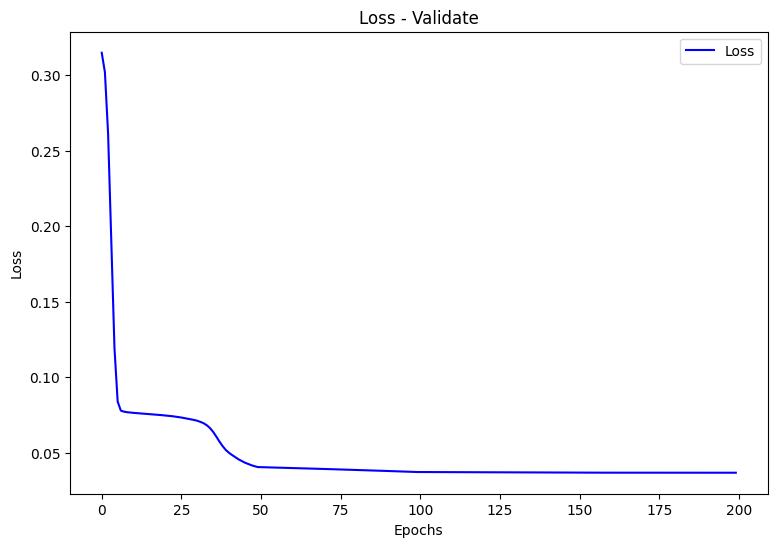

In [1]:
continue_training_epochs = 100  # Number of additional epochs to run
model_checkpoint = 'SRCNN_checkpoint_epoch_99.pth'  # Specify the checkpoint file to continue from
# model_checkpoint = None

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
from google.colab import drive
from pathlib import Path

%load_ext google.colab.data_table

class Config():
    SRCNN_path = 'SRCNN/'
    content_path = f'/content/drive/MyDrive/{SRCNN_path}'
    data_path = './data/'

    content_path = Path(content_path)

    GPU = True
    device = torch.device("cuda" if torch.cuda.is_available() and GPU else "cpu")

    batch_size = 16
    num_epochs = continue_training_epochs

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    @staticmethod
    def low_res_transform():
        return transforms.Compose([
            transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1.5, 1.5)), # Gaussian blur
            transforms.Resize(224 // 3, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        ])

    hr_train_dir = content_path / 'DIV2K_train_HR'
    hr_val_dir = content_path / 'DIV2K_valid_HR'


class Setup():
    def __init__(self, config):
        self.config = config
        self.mount()
        self.make_dir()
        self.seed()

    def mount(self):
        drive.mount('/content/drive/')

    def make_dir(self):
        if not os.path.exists(self.config.content_path / 'Models/'):
            os.makedirs(self.config.content_path / 'Models/')
        if not os.path.exists(self.config.data_path):
            os.makedirs(self.config.data_path)

    def seed(self):
        if torch.cuda.is_available():
            torch.backends.cudnn.deterministic = True
            torch.manual_seed(0)

class SRDataset(Dataset):
    def __init__(self, hr_image_dir, transform=None, low_res_transform=None):
        self.hr_image_dir = hr_image_dir
        self.hr_image_filenames = os.listdir(hr_image_dir)
        self.transform = transform
        self.low_res_transform = low_res_transform

    def __len__(self):
        return len(self.hr_image_filenames)

    def __getitem__(self, idx):
        hr_image_path = os.path.join(self.hr_image_dir, self.hr_image_filenames[idx])
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform:
            hr_image = self.transform(hr_image)

        lr_image = self.low_res_transform(hr_image) if self.low_res_transform else hr_image

        return lr_image, hr_image

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.patch_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4),
            nn.ReLU()
        )
        self.non_linear_mapping = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.reconstruction = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2),
        )
        self.initialise_weights()

    def initialise_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.001)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.patch_extraction(x)
        x = self.non_linear_mapping(x)
        x = self.reconstruction(x)
        return x

class SRCNNTrainer():
    def __init__(self, config):
        self.config = config
        self.device = config.device
        self.batch_size = config.batch_size
        self.num_epochs = config.num_epochs
        self.transform = config.transform
        self.low_res_transform = config.low_res_transform()
        self.psnr = {'Train': [], 'Validate': []}
        self.loss = {'Train': [], 'Validate': []}
        self.model = SRCNN().to(self.device)
        self.optimizer, self.scheduler = self.initialise_optimizer()
        self.train_dataloader, self.val_dataloader = self.initialise_dataset()

    def initialise_optimizer(self):
        params_to_optimize = [
            {"params": self.model.patch_extraction.parameters(), "lr": 1e-4, "weight_decay": 1e-6},
            {"params": self.model.non_linear_mapping.parameters(), "lr": 1e-4, "weight_decay": 1e-6},
            {"params": self.model.reconstruction.parameters(), "lr": 1e-5, "weight_decay": 1e-6}
        ]
        optimizer = torch.optim.Adam(params_to_optimize)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Adjust the learning rate every 50 epochs
        return optimizer, scheduler

    def initialise_dataset(self):
        train_dataset = SRDataset(self.config.hr_train_dir, transform=self.transform, low_res_transform=self.low_res_transform)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataset = SRDataset(self.config.hr_val_dir, transform=self.transform, low_res_transform=self.low_res_transform)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        return train_dataloader, val_dataloader

    def model_output(self):
        params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print("Total number of parameters is: {}".format(params))
        print(self.model)

    def loss_MSE(self, input, target):
        loss = nn.MSELoss()
        mse_loss = loss(input, target)
        max_pixel = 1.0
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse_loss))
        return mse_loss, psnr

    def save_checkpoint(self, epoch):
        checkpoint_path = self.config.content_path / f'Models/SRCNN_checkpoint_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'loss': self.loss,
            'psnr': self.psnr
        }, checkpoint_path)

    def load_checkpoint(self, checkpoint_path):
        if checkpoint_path.exists():
            checkpoint = torch.load(checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # Load scheduler state
            self.loss = checkpoint['loss']
            self.psnr = checkpoint['psnr']
            start_epoch = checkpoint['epoch'] + 1
            return start_epoch
        else:
            return 0

    def save_metrics(self):
        metrics_path = self.config.content_path / 'Models/metrics.txt'
        with open(metrics_path, 'w') as f:
            for epoch in range(len(self.loss['Train'])):
                if epoch % 20 == 0 or epoch == len(self.loss['Train']) - 1:
                    f.write(f"Epoch {epoch}:\n")
                    f.write(f"Train Loss: {self.loss['Train'][epoch]}\n")
                    f.write(f"Train PSNR: {self.psnr['Train'][epoch]}\n")
                    f.write(f"Validate Loss: {self.loss['Validate'][epoch]}\n")
                    f.write(f"Validate PSNR: {self.psnr['Validate'][epoch]}\n")

    def training(self, checkpoint_path):
        start_epoch = self.load_checkpoint(checkpoint_path)
        self.model.train()
        try:
            for epoch in range(start_epoch, start_epoch + self.num_epochs):
                training_loss = 0
                psnr_total = 0
                with tqdm.tqdm(self.train_dataloader, unit="batch") as tepoch:
                    for batch_idx, (low, high) in enumerate(tepoch):
                        high_res = high.to(self.device)
                        low_res = low.to(self.device)
                        self.optimizer.zero_grad()
                        reconstructed_images = self.model(low_res)
                        loss, psnr = self.loss_MSE(reconstructed_images, high_res)
                        loss.backward()
                        psnr_total += psnr.item()
                        training_loss += loss.item()
                        self.optimizer.step()
                        if batch_idx % 20 == 0:
                            tepoch.set_description(f"Epoch {epoch}")
                            tepoch.set_postfix(loss=loss.item()/len(high_res), psnr=psnr.item())
                self.psnr['Train'].append(psnr_total/len(tepoch))
                self.loss['Train'].append(training_loss/len(tepoch))
                self.scheduler.step()
                self.validate()
                if epoch % 20 == 0 or epoch == start_epoch + self.num_epochs - 1:
                    self.save_checkpoint(epoch)
            self.save_metrics()
        except Exception as e:
            print(f"Training interrupted at epoch {epoch}: {e}")
            self.save_checkpoint(epoch)

    def validate(self):
        self.model.eval()
        valid_loss = 0
        psnr_total = 0
        with torch.no_grad():
            with tqdm.tqdm(self.val_dataloader, unit="batch") as tepoch:
                for batch_idx, (low, high) in enumerate(tepoch):
                    high_res = high.to(self.device)
                    low_res = low.to(self.device)
                    reconstructed_images = self.model(low_res)
                    loss, psnr = self.loss_MSE(reconstructed_images, high_res)
                    valid_loss += loss.item()
                    psnr_total += psnr.item()
                    if batch_idx % 20 == 0:
                        tepoch.set_description(f"Test")
                        tepoch.set_postfix(loss=loss.item()/len(high_res))
            self.psnr['Validate'].append(psnr_total/len(tepoch))
            self.loss['Validate'].append(valid_loss/len(tepoch))


class Results():
    def __init__(self, model, device, content_path):
        self.model = model
        self.device = device
        self.content_path = content_path

    def denorm(self, x):
        device = x.device
        mean = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
        std = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
        x = x * std + mean
        return x

    def display_dataset(self, val_dataloader, low_res_transform):
        sample_inputs, _ = next(iter(val_dataloader))
        fixed_input = sample_inputs[0:32, :, :, :]
        # visualize the original images of the last batch of the test set
        img = make_grid(self.denorm(fixed_input), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
        plt.figure()
        self.show(img)
        plt.savefig(self.content_path / "high_res.png")

        sample_inputs, _ = next(iter(val_dataloader))
        fixed_input = sample_inputs[0:32, :, :, :]
        # visualize the original images of the last batch of the test set
        img = make_grid(self.denorm(low_res_transform(fixed_input)), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
        plt.figure()
        self.show(img)
        plt.savefig(self.content_path / "low_res.png")

        print('-' * 50)
        with torch.no_grad():
            recon_batch = self.model(fixed_input.to(self.device))
            recon_batch = recon_batch.cpu()
            recon_batch = make_grid(self.denorm(recon_batch), nrow=8, padding=2, normalize=False,
                                    value_range=None, scale_each=False, pad_value=0)
            plt.figure()
            self.show(recon_batch)
            plt.savefig(self.content_path / "recon_images.png")

    def plot_loss_psnr(self, psnr, loss):
        plt.figure(figsize=(9, 6))
        plt.plot(psnr['Train'], color='red', label='PSNR')
        plt.title("PSNR - Training")
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.legend()
        plt.savefig(self.content_path / "training_psnr.png")

        plt.figure(figsize=(9, 6))
        plt.plot(loss['Train'], color='blue', label='Loss')
        plt.title("Loss - Training")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.content_path / "training_loss.png")

        plt.figure(figsize=(9, 6))
        plt.plot(psnr['Validate'], color='red', label='PSNR')
        plt.title("PSNR - Validate")
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.legend()
        plt.savefig(self.content_path / "validate_psnr.png")

        plt.figure(figsize=(9, 6))
        plt.plot(loss['Validate'], color='blue', label='Loss')
        plt.title("Loss - Validate")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.content_path / "validate_loss.png")

    def show(self, img):
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

class ImageProcessor():
    def __init__(self, model, device, content_path):
        self.model = model
        self.device = device
        self.content_path = content_path

    def load_image(self, image_path):
        img = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        img = transform(img).unsqueeze(0)
        return img

    def process_image(self, image_path):
        img = self.load_image(image_path)
        img = img.to(self.device)
        self.model.eval()
        with torch.no_grad():
            output = self.model(img)

        denorm_output = self.denorm(output)
        output = torch.nn.functional.interpolate(denorm_output, size=(224, 224), mode='bilinear', align_corners=False)
        input_image = torch.nn.functional.interpolate(self.denorm(img), size=(224, 224), mode='bilinear', align_corners=False)
        return input_image, output

    def denorm(self, x):
        device = x.device
        mean = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
        std = torch.tensor([0.5, 0.5, 0.5], device=device).view(3, 1, 1)
        x = x * std + mean
        return x

    def display_and_save_image(self, input_image, output_image):
        recon_batch = make_grid(output_image, nrow=8, padding=2, normalize=False, value_range=None, scale_each=False, pad_value=0)
        image_output = make_grid(input_image, nrow=8, padding=2, normalize=False, value_range=None, scale_each=False, pad_value=0)

        plt.figure()
        self.show(image_output)
        plt.figure()
        self.show(recon_batch)

        save_image(output_image, os.path.join(self.content_path, 'reconstructed_image.png'))

    def show(self, img):
        npimg = img.cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def main():
    config = Config()
    setup = Setup(config)
    trainer = SRCNNTrainer(config)
    checkpoint_path = config.content_path / f'Adam with scheduler/{model_checkpoint}'
    start_epoch = trainer.load_checkpoint(checkpoint_path)
    if start_epoch == 0:
        print("No checkpoint found. Training from scratch.")
    trainer.training(checkpoint_path)

    tester = Results(trainer.model, trainer.device, config.content_path)
    tester.display_dataset(trainer.val_dataloader, trainer.low_res_transform)
    tester.plot_loss_psnr(trainer.psnr, trainer.loss)

if __name__ == "__main__":
    main()